# Crowding
This notebook aims to modify the heterotroph dispersal to include crowding effect. Crowding is a density-dependent factor that limits the growth of a population. This means that the emigration of the heterotroph increases with increasing population density.

## Crowding with linear scaling
$d_{i,x} = H_0 \cdot H + cons.$, with $H_0$ being the slope of the dispersal function and $H$ the heterotroph density.

### Packages

In [51]:
import numpy as np
from scipy import integrate as integ
from scipy import signal as signal
import sympy as sp
import matplotlib
from matplotlib.lines import Line2D
from matplotlib import pyplot as plt
import seaborn as sns
import ipywidgets
from tqdm import tqdm
from turing_model import TuringModel as tm
from scipy.stats import linregress

### Model

In [52]:
def slow(var, t):
    # fill var
    N_a = var[0]
    N_b = var[1]
    A_a = var[2]
    A_b = var[3]
    H_1a = var[4]
    H_1b = var[5]
    H_2a = var[6]
    H_2b = var[7]
    d_H1a = var[8]
    d_H2a = var[9]
    d_H1b = var[10]
    d_H2b = var[11]

    # growth rate of autotrophs
    r_a = (r_max * N_a) / (N_h + N_a)
    r_b = (r_max * N_b) / (N_h + N_b)

    # growth rate of competitors
    g_1a = (a_1 * A_a) / (1 + a_1 * h * A_a)
    g_1b = (a_1 * A_b) / (1 + a_1 * h * A_b)
    g_2a = (a_2 * A_a) / (1 + a_2 * h * A_a)
    g_2b = (a_2 * A_b) / (1 + a_2 * h * A_b)

    # # inflection points
    # x_01 = D / (a_1 * (e - h * D))
    # x_02 = D / (a_2 * (e - h * D))
    
    # dispersal rates of competitors
    d_H1a = c_1 * (H_1a + H_2a)
    d_H1b = c_1 * (H_1b + H_2b)
    d_H2a = c_2 * (H_2a + H_1a)
    d_H2b = c_2 * (H_2b + H_1b)

    # change of nutrients
    dN_a = D * (S - N_a) - r_a * A_a + d_N * (N_b - N_a)
    dN_b = D * (S - N_b) - r_b * A_b + d_N * (N_a - N_b)

    # change of autotrophs
    dA_a = r_a * A_a - ((g_1a * H_1a) + (g_2a * H_2a)) - D * A_a + d_A * (A_b - A_a)
    dA_b = r_b * A_b - ((g_1b * H_1b) + (g_2b * H_2b)) - D * A_b + d_A * (A_a - A_b)

    # change of competitors
    dH_1a = e * g_1a * H_1a - D * H_1a - d_H1a * H_1a + d_H1b * H_1b
    dH_1b = e * g_1b * H_1b - D * H_1b - d_H1b * H_1b + d_H1a * H_1a
    dH_2a = e * g_2a * H_2a - D * H_2a - d_H2a * H_2a + d_H2b * H_2b
    dH_2b = e * g_2b * H_2b - D * H_2b - d_H2b * H_2b + d_H2a * H_2a

    return(dN_a, dN_b, dA_a, dA_b, dH_1a, dH_1b, dH_2a, dH_2b, d_H1a, d_H2a, d_H1b, d_H2b)

### Initialisation

In [53]:
# var
var = []

# set parameters
S = 4.8 # Nutrient supply concentration
D = 0.3 # Dilution rate
N_h = 1.5 # half saturation constant for nutrient uptake
r_max = 0.7 # growth rate of autotroph
h = 0.53 # handling time
e = 0.33 # conversion efficiency of competitor
d_N = 1 # Dispersal rate of nutrients 
d_A = 0.001 # dispersal rate of autotrophs

# competitiveness 
a_1 = 1 # attack rate of competitor 1 
a_2 = 1 # attack rate of competitor 2 

# adaptability
k_1 = 2 # dispersal adaptability of competitor 1 
k_2 = 2 # dispersal adaptability of competitor 2 
        # 0 = random dispersal, 2 = adaptive dispersal

# dispersal speed 
d_Hmax1 = 0.1 # maximal dispersal rates of competitor 1  
d_Hmax2 = 0.1 # maximal dispersal rates of competitor 2  

# time series
t_end = 10000
number_steps = 10000
t = np.linspace(0,t_end,number_steps)

# initials:[N_a, N_b, A_a, A_b, H_1a, H_1b, H_2a, H_2b]
var0 = [2, 2.5, 2.5, 2, 0.08, 0.4, 0.08, 0.4, 0, 0, 0, 0]

C:\Users\rmjar\AppData\Local\Temp\ipykernel_10780\3540383929.py:27: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(-1,1)


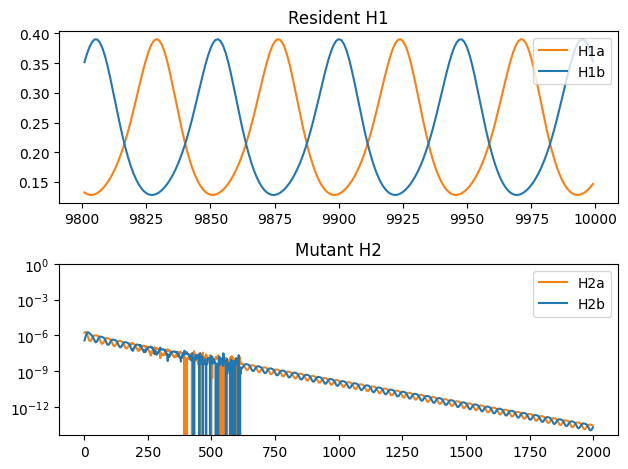

In [54]:
# time series
t_end = 10000
number_steps = 10000
t = np.linspace(0,t_end,number_steps)

c_1 = 0.03
c_2 = 10
var0 = [2, 2.5, 2.5, 2, 0.08, 0.4, 10**-6, 10**-6, 0, 0, 0, 0]
var = []
var = integ.odeint(slow, var0, t)
# for i in range(len(var)):
#     for j in range (len(var[i])):
#         if (var[i][j] < 10**-6):
#             var[i][j] = 0
plt.subplot2grid((2,1),(0,0))
plt.plot(t[-200:-1], var[-200:-1:, 4], "-", color="#FF7F0E", label="H1a")
plt.plot(t[-200:-1], var[-200:-1:, 5], "-", color="#1F77B4", label="H1b")
plt.legend(loc=1)
plt.title("Resident H1")
plt.subplot2grid((2,1),(1,0))
plt.title("Mutant H2")
plt.plot(t[1:2000], var[1:2000, 6], "-", color="#FF7F0E", label="H2a")
plt.plot(t[1:2000], var[1:2000, 7], "-", color="#1F77B4", label="H2b")
# plt.plot(t[-200:-1], var[-200:-1:, 6], "-", color="#FF7F0E", label="H2a")
# plt.plot(t[-200:-1], var[-200:-1:, 7], "-", color="#1F77B4", label="H2b")
plt.yscale("log")
plt.ylim(-1,1)
plt.legend(loc=1)
plt.tight_layout()

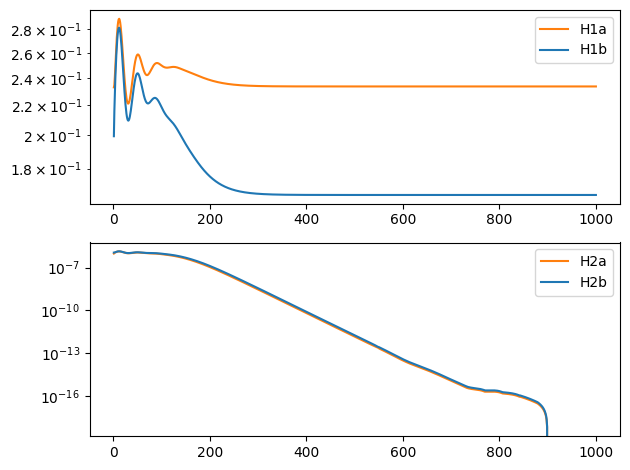

In [217]:
t_end = 1000
number_steps = 1000
t = np.linspace(0,t_end,number_steps)
c_1 = 1
c_2 = 5
var0 = [2, 2.5, 2.5, 2, 0.24, 0.175, 10**-6, 10**-6, 0, 0, 0, 0]
var = []
var = integ.odeint(slow, var0, t)
plt.subplot2grid((2,1),(0,0))
plt.plot(t[1:1000], var[1:1000:, 4], "-", color="#FF7F0E", label="H1a")
plt.plot(t[1:1000], var[1:1000:, 5], "-", color="#1F77B4", label="H1b")
plt.yscale("log")
plt.legend()
plt.subplot2grid((2,1),(1,0))
plt.plot(t[1:1000], var[1:1000:, 6], "-", color="#FF7F0E", label="H2a")
plt.plot(t[1:1000], var[1:1000:, 7], "-", color="#1F77B4", label="H2b")
plt.yscale("log")
plt.legend()
plt.tight_layout()

In [215]:
from scipy.stats import linregress
linregress(np.linspace(50, 150, 400),np.log(var[0:400:, 6]))[0]

0.15077484096445376

In [5]:
c_range = np.geomspace(0.0001, 10, 50)
t_end = 10000
number_steps = 1000
t = np.linspace(0,t_end,number_steps)

var0 = [2, 2.5, 2.5, 2, 0.08, 0.4, 0.08, 0.4, 0, 0, 0, 0]

density_H1x = np.zeros((len(c_range), len(c_range)))
density_H1y = np.zeros((len(c_range), len(c_range)))
density_H2x = np.zeros((len(c_range), len(c_range)))
density_H2y = np.zeros((len(c_range), len(c_range)))
checkOsc_H1x = np.zeros((len(c_range), len(c_range)))
checkOsc_H1y = np.zeros((len(c_range), len(c_range)))
checkOsc_H2x = np.zeros((len(c_range), len(c_range)))
checkOsc_H2y = np.zeros((len(c_range), len(c_range)))
meandensity_H1x = np.zeros((len(c_range), len(c_range)))
meandensity_H1y = np.zeros((len(c_range), len(c_range)))
meandensity_H2x = np.zeros((len(c_range), len(c_range)))
meandensity_H2y = np.zeros((len(c_range), len(c_range)))

In [6]:
var = []

i = 0
j = 0

for c_2 in tqdm(c_range):
    j = 0
    for c_1 in c_range:
        var = integ.odeint(slow, var0, t)

        # results[i,j] = ...
        density_H1x[i, j] = var[-1, 4]
        density_H1y[i, j] = var[-1, 5]
        density_H2x[i, j] = var[-1, 6]
        density_H2y[i, j] = var[-1, 7]

        checkOsc_H1x[i, j] = np.var(var[-200:-1, 4])
        checkOsc_H1y[i, j] = np.var(var[-200:-1, 5])
        checkOsc_H2x[i, j] = np.var(var[-200:-1, 6])
        checkOsc_H2y[i, j] = np.var(var[-200:-1, 7])

        meandensity_H1x[i, j] = np.mean(var[-200:-1, 4])
        meandensity_H1y[i, j] = np.mean(var[-200:-1, 5])
        meandensity_H2x[i, j] = np.mean(var[-200:-1, 6])
        meandensity_H2y[i, j] = np.mean(var[-200:-1, 7])

        j += 1
    i += 1


100%|██████████| 50/50 [14:04<00:00, 16.88s/it]


In [9]:
# save lib is not final yet since depending on the task, further additions may be needed.
# The model is already saving a bunch of other data and I'm not sure if they are needed.
initials = np.array(var0)
save_lib = {
    "density_H1x": density_H1x,
    "density_H1y": density_H1y,
    "density_H2x": density_H2x,
    "density_H2y": density_H2y,
    "checkOsc_H1x": checkOsc_H1x,
    "checkOsc_H1y": checkOsc_H1y,
    "checkOsc_H2x": checkOsc_H2x,
    "checkOsc_H2y": checkOsc_H2y,
    "meandensity_H1x": meandensity_H1x,
    "meandensity_H1y": meandensity_H1y,
    "meandensity_H2x": meandensity_H2x,
    "meandensity_H2y": meandensity_H2y,
    "initials": initials
}
#tm.savedata("./crowding/231006-c-newcrowding/", save_lib)
load_list = ["density_H1x", "density_H1y", "density_H2x", "density_H2y", "checkOsc_H1x", "checkOsc_H1y", "checkOsc_H2x", "checkOsc_H2y", "meandensity_H1x",
             "meandensity_H1y", "meandensity_H2x", "meandensity_H2y", "initials"]
# tm.loaddata("foldername", load_list)

C:\Users\rmjar\AppData\Local\Temp\ipykernel_12520\1864118133.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


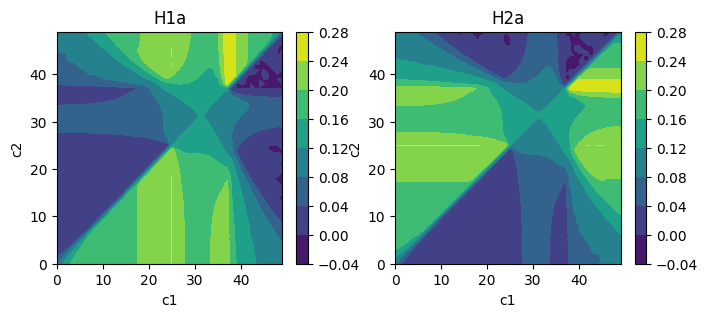

In [9]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8), gridspec_kw={'top': 0.4})
im1 = ax1.contourf(meandensity_H1x, cmap="viridis")#, vmin = -0.04, vmax = 0.28)
im2 = ax2.contourf(meandensity_H2x, cmap="viridis")#, vmin = -0.04, vmax = 0.28)
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
ax1.set_title("H1a")
ax2.set_title("H2a")
ax1.set_xlabel("c1")
ax1.set_ylabel("c2")
ax2.set_xlabel("c1")
ax2.set_ylabel("c2")
plt.tight_layout()
plt.show()

C:\Users\UGEW Support\AppData\Local\Temp\ipykernel_8488\1147993672.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


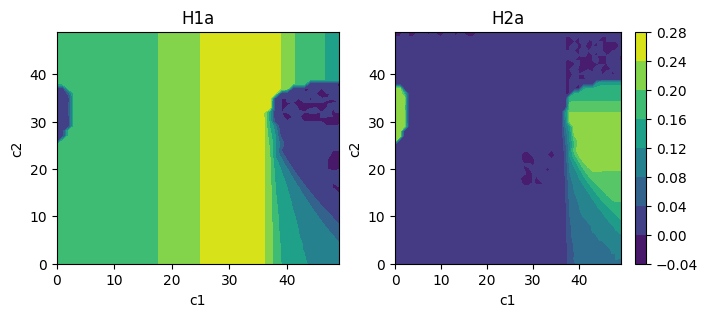

In [38]:
df = tm.loaddata("./crowding/231006-c-newcrowding/", load_list)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8), gridspec_kw={'top': 0.4})
im1 = ax1.contourf(df["meandensity_H1x"], cmap="viridis", vmin = -0.04, vmax = 0.28)
im2 = ax2.contourf(df["meandensity_H2x"], cmap="viridis", vmin = -0.04, vmax = 0.28)
# fig.colorbar(im1, ax=ax1)
# fig.colorbar(im2, ax=ax2)
fig.colorbar(im1, ax=ax2)
ax1.set_title("H1a")
ax2.set_title("H2a")
ax1.set_xlabel("c1")
ax1.set_ylabel("c2")
ax2.set_xlabel("c1")
ax2.set_ylabel("c2")
plt.tight_layout()
plt.show()

C:\Users\UGEW Support\AppData\Local\Temp\ipykernel_8488\2225686825.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


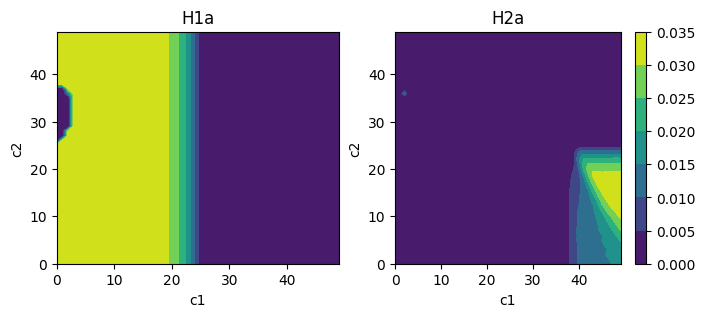

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8), gridspec_kw={'top': 0.4})
im1 = ax1.contourf(df["checkOsc_H1x"], cmap="viridis")
im2 = ax2.contourf(df["checkOsc_H2x"], cmap="viridis")
# fig.colorbar(im1, ax=ax1)
# fig.colorbar(im2, ax=ax2)
fig.colorbar(im1, ax=ax2)
ax1.set_title("H1a")
ax2.set_title("H2a")
ax1.set_xlabel("c1")
ax1.set_ylabel("c2")
ax2.set_xlabel("c1")
ax2.set_ylabel("c2")
plt.tight_layout()
plt.show()

In [22]:
len(var[0:99,6])

99

## Invasion

In [ ]:
def find_maxima(x,n):
    """ returns an array with n extreme values of x"""
    
    max_index = signal.argrelmax(x)[0]         # create array with indices of local maxima of x
    
    extrema = x[max_index]                     # array with the actual values of the extrema
       
    if len(extrema) == 0:                      # if all values in x are the same and no extremum is found:
        extrema = np.append(extrema,x[-1])     #   return last value of x in this case
    while len(extrema) < n:                    # if less than n extrema have been found:
        extrema = np.append(extrema,extrema[0])#   repeat last extremum until array has n elements
    while len(extrema) > n:                    # if more than n extrema have been found:
        extrema = np.delete(extrema,-1)        #   delete elements until arrays has n elements
        
    return extrema

In [21]:
t_end = 500
number_steps = 500
t = np.linspace(0, t_end, number_steps)

# dispersal adaptability
c_range = np.geomspace(0.001, 10, 50) #100

# var = [N_a, N_b, A_a, A_b, H_1a, H_1b, H_2a, H_2b]
var0 = [2, 2.5, 2.5, 2, 0.2, 0.3, 0, 0, 0, 0, 0, 0]

num_extr = 5 # set number of maxima to be found

H2a_extr = []
H2b_extr = []
H1_extr = []
H2_extr = []
slopeH2a = np.zeros((len(c_range), len(c_range)))
slopeH2b = np.zeros((len(c_range), len(c_range)))
slopeH2 = np.zeros((len(c_range), len(c_range)))
H2end = np.zeros((len(c_range), len(c_range)))

var = []

i = 0
j = 0

for c_2 in tqdm(c_range):
    j = 0
    for c_1 in c_range:
        var0 = [2, 2.5, 2.5, 2, 0.2, 0.3, 0, 0, 0, 0, 0, 0]
        var = integ.odeint(slow, var0, t)
        #var[var < 1e-10] = 1e-10

        var0 = [var[-1,0], var[-1,1], var[-1,2], var[-1,3], var[-1,4], var[-1,5], 10**-6, 10**-6, 0, 0, 0, 0]
        var = integ.odeint(slow, var0, t)

        # results[i,j] = ...
        slopeH2a[i, j] = linregress(np.linspace(50, 150, 100),np.log(var[0:100,6]))[0]
        slopeH2b[i, j] = linregress(np.linspace(50, 150, 100),np.log(var[0:100,7]))[0]
        slopeH2[i, j] = linregress(np.linspace(50, 150, 100),np.log(var[0:100,6])+np.log(var[0:100,7]))[0]
        H2end[i,j] = (np.mean(var[-100:-1,6]))+(np.mean(var[-100:-1,7]))

        # workaround to empty lists
        H1_extr = []
        H2_extr = []

        j += 1
    i += 1

  0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_2677/3767444487.py:38: RuntimeWarning: invalid value encountered in log
  slopeH2a[i, j] = linregress(np.linspace(50, 150, 100),np.log(var[0:100,6]))[0]
/tmp/ipykernel_2677/3767444487.py:39: RuntimeWarning: invalid value encountered in log
  slopeH2b[i, j] = linregress(np.linspace(50, 150, 100),np.log(var[0:100,7]))[0]
/tmp/ipykernel_2677/3767444487.py:40: RuntimeWarning: invalid value encountered in log
  slopeH2[i, j] = linregress(np.linspace(50, 150, 100),np.log(var[0:100,6])+np.log(var[0:100,7]))[0]
100%|██████████| 50/50 [01:36<00:00,  1.93s/it]


In [ ]:
t_end = 500
number_steps = 500
t = np.linspace(0, t_end, number_steps)

# dispersal adaptability
c_range = np.geomspace(0.001, 10, 50) #100

# var = [N_a, N_b, A_a, A_b, H_1a, H_1b, H_2a, H_2b]
var0 = var0 = [2, 2.5, 2.5, 2, 0.2, 0.3, 10**-6, 10**-6, 0, 0, 0, 0]

num_extr = 5 # set number of maxima to be found

H2a_extr = []
H2b_extr = []
H1_extr = []
H2_extr = []
slopeH2a = np.zeros((len(c_range), len(c_range)))
slopeH2b = np.zeros((len(c_range), len(c_range)))
slopeH2 = np.zeros((len(c_range), len(c_range)))
H2end = np.zeros((len(c_range), len(c_range)))

var = []

i = 0
j = 0

for c_2 in tqdm(c_range):
    j = 0
    for c_1 in c_range:
        var = integ.odeint(slow, var0, t)
        var[var < 1e-10] = 1e-10

        # results[i,j] = ...
        slopeH2a[i, j] = linregress(np.linspace(50, 150, 100),np.log(var[0:100,6]))[0]
        slopeH2b[i, j] = linregress(np.linspace(50, 150, 100),np.log(var[0:100,7]))[0]
        slopeH2[i, j] = linregress(np.linspace(50, 150, 100),np.log(var[0:100,6])+np.log(var[0:100,7]))[0]
        H2end[i,j] = (np.mean(var[-100:-1,6]))+(np.mean(var[-100:-1,7]))

        # workaround to empty lists
        H1_extr = []
        H2_extr = []

        j += 1
    i += 1

# for c_2 in tqdm(c_range):
#     j = 0
#     for c_1 in c_range:
#         var = integ.odeint(slow, var0, t)

#         H2a_extr.append(find_maxima(np.log(var[0:400,6]),num_extr))
#         H2b_extr.append(find_maxima(np.log(var[0:400,7]),num_extr))

#         # results[i,j] = ...
#         slopeH2a[i, j] = linregress(np.linspace(1, 9, 5),H2a_extr[0][0:num_extr])[0]
#         slopeH2b[i, j] = linregress(np.linspace(1, 9, 5),H2b_extr[0][0:num_extr])[0]

#         # workaround to empty lists
#         H2a_extr = []
#         H2b_extr = []

#         j += 1
#     i += 1

# np.savetxt("./data/crowding/growthrate/H1Slope.csv", slopeH1, delimiter=",")
# np.savetxt("./data/crowding/growthrate/H2Slope.csv", slopeH2, delimiter=",")

[Text(0, 0.0, '$10^{-3}$'),
 Text(0, 12.5, '$10^{-2}$'),
 Text(0, 25.0, '$10^{-1}$'),
 Text(0, 37.5, '$10^{0}$'),
 Text(0, 50.0, '$10^{1}$')]

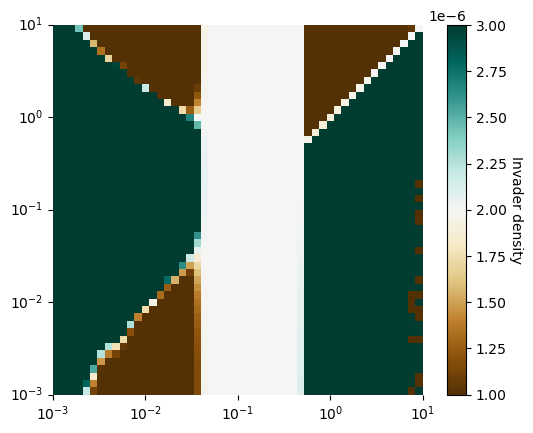

In [26]:
ax3 = sns.heatmap(H2end, cmap="BrBG", square=True, cbar = False, vmin=1*10**-6, vmax=3*10**-6)
ticks = np.append(c_range, 10)
cbar3 = ax3.figure.colorbar(ax3.collections[0])
cbar3.set_label('Invader density', rotation=270, labelpad=12)
ax3.set_xticks(np.linspace(0, len(c_range), 5))
ax3.set_yticks(np.linspace(0, len(c_range), 5))
ax3.invert_yaxis()
ax3.set_xticklabels(("$10^{-3}$", "$10^{-2}$", "$10^{-1}$", "$10^{0}$", "$10^{1}$"), rotation=0)
ax3.set_yticklabels(("$10^{-3}$", "$10^{-2}$", "$10^{-1}$", "$10^{0}$", "$10^{1}$"))

Text(0, 0.5, '$c_2$')

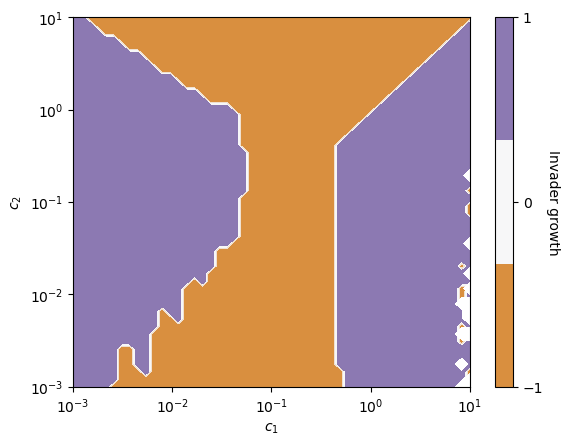

In [24]:
#slopeH2 = np.loadtxt("./data/crowding/growthrate/H2Slope.csv", delimiter=",")
slopeH2bin = np.copy(slopeH2)
slopeH2bin[slopeH2bin < 2*10**-6] = -1
slopeH2bin[slopeH2bin >= 2*10**-6] = 1

fig, ax = plt.subplots()
im = plt.contourf(slopeH2bin, cmap="PuOr", levels=np.linspace(-1, 1, 4), alpha=0.8)
cbar = fig.colorbar(im)
cbar.set_ticks([-1, 0, 1])
cbar.set_label('Invader growth', rotation=270, labelpad=12)
#plt.plot([0, 99], [0, 99], color="black", linestyle="--", linewidth=0.5, alpha = 0.5)
ax.set_xticks(np.linspace(0, len(c_range)-1, 5))
ax.set_yticks(np.linspace(0, len(c_range)-1, 5))
ax.set_xticklabels(("$10^{-3}$", "$10^{-2}$", "$10^{-1}$", "$10^{0}$", "$10^{1}$"), rotation=0)
ax.set_yticklabels(("$10^{-3}$", "$10^{-2}$", "$10^{-1}$", "$10^{0}$", "$10^{1}$"))
ax.set_xlabel('$c_1$')
ax.set_ylabel('$c_2$')

Text(113.9222222222222, 0.5, '$c_2$')

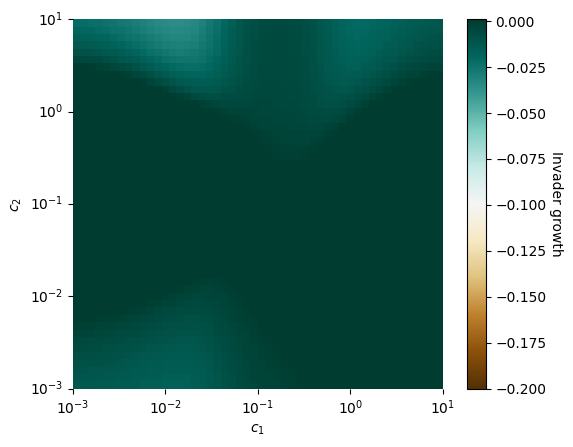

In [89]:
# H2 change
#slopeH2 = np.loadtxt("./data/crowding/growthrate/H2Slope.csv", delimiter=",")
fig, ax3 = plt.subplots()
ax3 = sns.heatmap(slopeH2a+slopeH2b, cmap="BrBG", square=True, cbar=False, vmin=-0.001, vmax=0.001)
ticks = np.append(c_range, 10)
cbar3 = ax3.figure.colorbar(ax3.collections[0])
cbar3.set_label('Invader growth', rotation=270, labelpad=12)
ax3.set_xticks(np.linspace(0, len(c_range), 5))
ax3.set_yticks(np.linspace(0, len(c_range), 5))
ax3.invert_yaxis()
ax3.set_xticklabels(("$10^{-3}$", "$10^{-2}$", "$10^{-1}$", "$10^{0}$", "$10^{1}$"), rotation=0)
ax3.set_yticklabels(("$10^{-3}$", "$10^{-2}$", "$10^{-1}$", "$10^{0}$", "$10^{1}$"))
#plt.grid(color='black', linewidth=0.5, linestyle='--')
#ax3.plot([0, len(c_range)], [0, len(c_range)], color="black", linestyle="--", linewidth=0.75)
plt.xlabel('$c_1$')
plt.ylabel('$c_2$')
# plt.title('Growth rate of $H_2$ \n $d_{H_{max}} = $' + str(d_Hmax) + ', H2 invader')
# plt.savefig('./output/final/invasion_growthrateV3_'+str(d_Hmax)+'_H2_logV2.png')

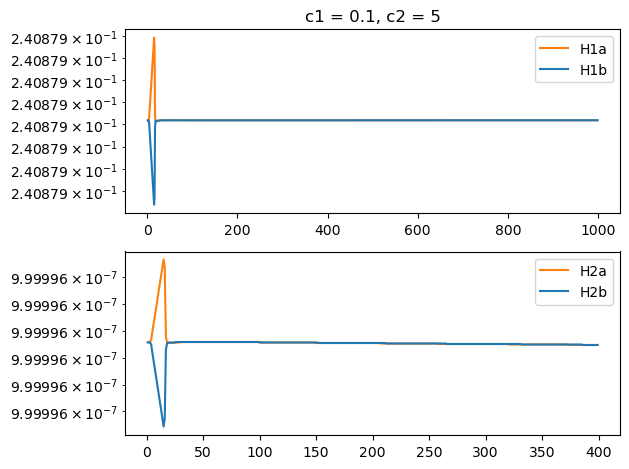

In [15]:
t_end = 40000
number_steps = 40000
t = np.linspace(0,t_end,number_steps)
c_1 = 0.11
c_2 = 0.095
var0 = [2, 2.5, 2.5, 2, 0.2, 0.3, 10**-6, 10**-6, 0, 0, 0, 0]
#var0 = [2, 2.5, 2.5, 2, 0.24, 0.175, 0.24, 0.175, 0, 0, 0, 0]
#var0 = [2, 2.5, 2.5, 2, 0.08, 0.4, 0.08, 0.4, 0, 0, 0, 0]
#var0 = [var[-1,0], var[-1,1], var[-1,2], var[-1,3], var[-1,4], var[-1,5], 10**-6, 10**-6, 0, 0, 0, 0]
#var0 = [var[-1,0], var[-1,1], var[-1,2], var[-1,3], var[-1,4], var[-1,5], var[-1,6], var[-1,7], 0, 0, 0, 0]
var = []
var = integ.odeint(slow, var0, t)
plt.subplot2grid((2,1),(0,0))
plt.plot(t[1:1000], var[1:1000:, 4], "-", color="#FF7F0E", label="H1a")
plt.plot(t[1:1000], var[1:1000:, 5], "-", color="#1F77B4", label="H1b")
plt.yscale("log")
plt.title("c1 = 0.1, c2 = 5")
plt.legend()
plt.subplot2grid((2,1),(1,0))
plt.plot(t[1:400], var[1:400:, 6], "-", color="#FF7F0E", label="H2a")
plt.plot(t[1:400], var[1:400:, 7], "-", color="#1F77B4", label="H2b")
plt.yscale("log")
plt.legend()
plt.tight_layout()

In [8]:
(np.mean(var[-100:-1,6]))+(np.mean(var[-100:-1,7]))

2.0344979948730105e-06

In [33]:
linregress(np.linspace(50, 150, 4000),np.log(var[0:4000:, 6])+np.log(var[0:4000:, 7]))[0]

-8.756138127172295e-06

Text(0, 0.5, '$c_2$')

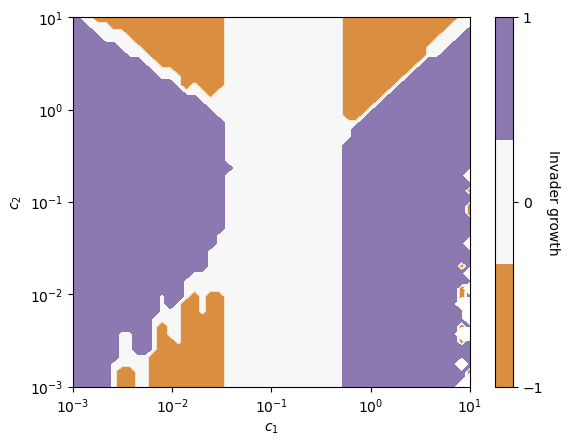

In [25]:
#slopeH2 = np.loadtxt("./data/crowding/growthrate/H2Slope.csv", delimiter=",")
slopefull = slopeH2a+slopeH2b
slopeH2bin = np.copy(slopefull)
slopeH2bin[slopeH2bin <= -6*10**-3] = -1
for i in range(len(slopeH2bin)):
    for j in range(len(slopeH2bin[i])):
        if (slopeH2bin[i][j] != -1) and (slopeH2bin[i][j] < 6*10**-3) and (slopeH2bin[i][j] > -6*10**-3):
            slopeH2bin[i][j] = 0
for i in range(len(slopeH2bin)):
    for j in range(len(slopeH2bin[i])):
        if ((slopeH2bin[i][j] >= 6*10**-3)):
            slopeH2bin[i][j] = 1

fig, ax = plt.subplots()
im = plt.contourf(slopeH2bin, cmap="PuOr", levels=np.linspace(-1, 1, 4), alpha=0.8)
cbar = fig.colorbar(im)
cbar.set_ticks([-1, 0, 1])
cbar.set_label('Invader growth', rotation=270, labelpad=12)
#plt.plot([0, 99], [0, 99], color="black", linestyle="--", linewidth=0.5, alpha = 0.5)
ax.set_xticks(np.linspace(0, len(c_range)-1, 5))
ax.set_yticks(np.linspace(0, len(c_range)-1, 5))
ax.set_xticklabels(("$10^{-3}$", "$10^{-2}$", "$10^{-1}$", "$10^{0}$", "$10^{1}$"), rotation=0)
ax.set_yticklabels(("$10^{-3}$", "$10^{-2}$", "$10^{-1}$", "$10^{0}$", "$10^{1}$"))
ax.set_xlabel('$c_1$')
ax.set_ylabel('$c_2$')

Text(0, 0.5, '$c_2$')

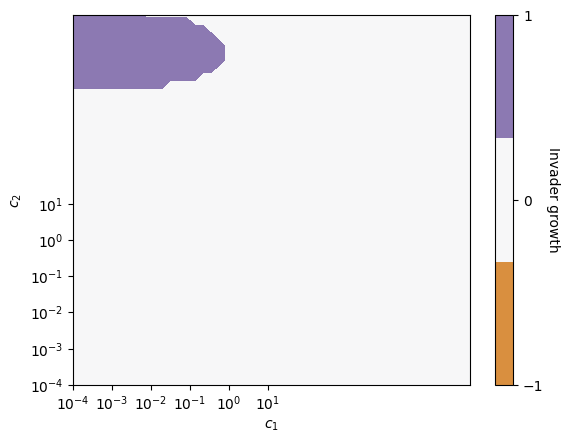

In [18]:
#slopeH2 = np.loadtxt("./data/crowding/growthrate/H2Slope.csv", delimiter=",")
slopeH2bin = np.copy(slopeH2a)
slopeH2bin[slopeH2bin <= -0.05] = -1
for i in range(len(slopeH2bin)):
    for j in range(len(slopeH2bin[i])):
        if (slopeH2bin[i][j] != -1) and (slopeH2bin[i][j] < 0.05) and (slopeH2bin[i][j] > -0.05):
            slopeH2bin[i][j] = 0
for i in range(len(slopeH2bin)):
    for j in range(len(slopeH2bin[i])):
        if ((slopeH2bin[i][j] >= 0.05)):
            slopeH2bin[i][j] = 1

fig, ax = plt.subplots()
im = plt.contourf(slopeH2bin, cmap="PuOr", levels=np.linspace(-1, 1, 4), alpha=0.8)
cbar = fig.colorbar(im)
cbar.set_ticks([-1, 0, 1])
cbar.set_label('Invader growth', rotation=270, labelpad=12)
#plt.plot([0, 99], [0, 99], color="black", linestyle="--", linewidth=0.5, alpha = 0.5)
ax.set_xticks(np.linspace(0, len(c_range)-1, 6))
ax.set_yticks(np.linspace(0, len(c_range)-1, 6))
ax.set_xticklabels(("$10^{-4}$", "$10^{-3}$", "$10^{-2}$", "$10^{-1}$", "$10^{0}$", "$10^{1}$"), rotation=0)
ax.set_yticklabels(("$10^{-4}$", "$10^{-3}$", "$10^{-2}$", "$10^{-1}$", "$10^{0}$", "$10^{1}$"))
ax.set_xlabel('$c_1$')
ax.set_ylabel('$c_2$')

## Time series: Random initialisation

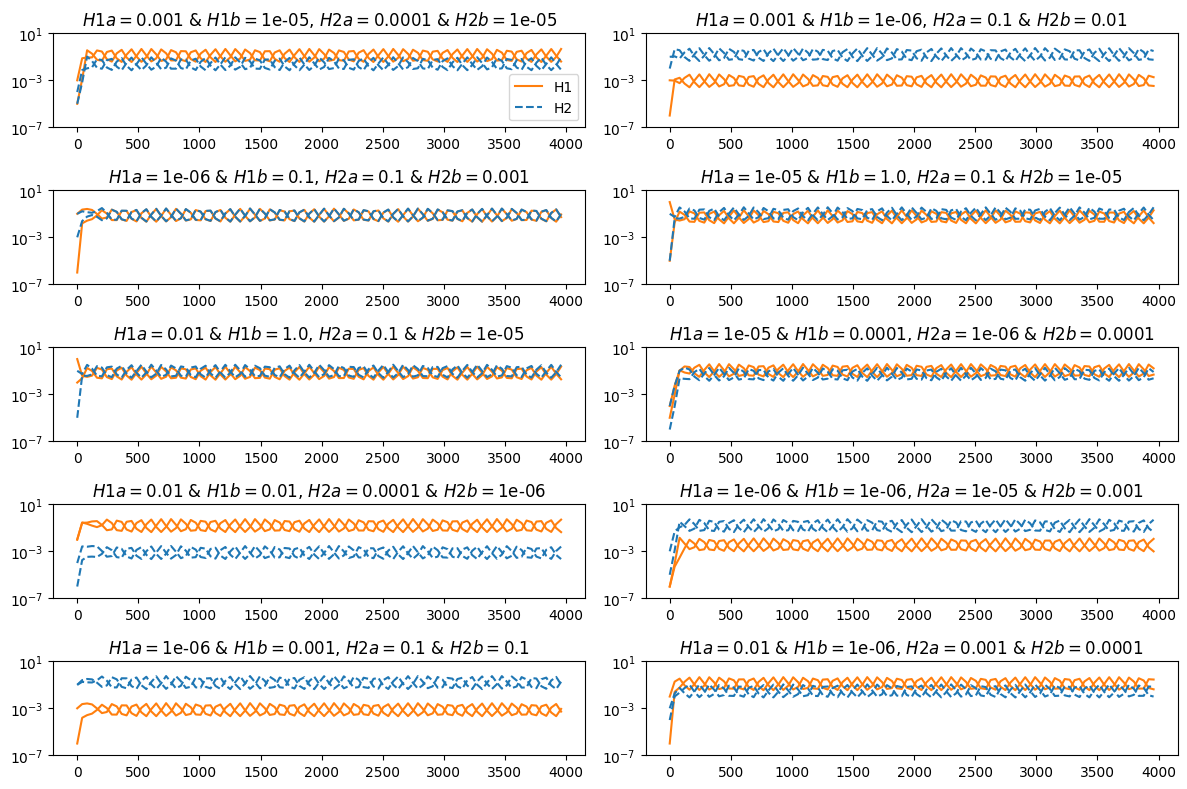

In [36]:
def rndpop():
    rnd = np.random.choice(np.geomspace(10**-6, 10**0, 7))
    return(rnd)

# time series
t_end = 4000
number_steps = 100
t = np.linspace(0,t_end,number_steps)

c_1 = 0.01
c_2 = 0.01

fig, axs = plt.subplots(5,2, figsize=(12,8))
for i in range(10):
    row = i//2
    col = i%2
    var0 = [2, 2.5, 2.5, 2, rndpop(), rndpop(), rndpop(), rndpop(), 0, 0, 0, 0]
    var = []
    var = integ.odeint(slow, var0, t)
    # for i in range(len(var)):
    #     for j in range (len(var[i])):
    #         if (var[i][j] < 10**-6):
    #             var[i][j] = 10**-6
    axs[row, col].plot(t[-100:-1], var[-100:-1:, 4], "-", color="#FF7F0E", label="H1")
    axs[row,col].plot(t[-100:-1], var[-100:-1:, 5], "-", color="#FF7F0E")
    axs[row,col].plot(t[-100:-1], var[-100:-1:, 6], "--", color="#1F77B4", label="H2")
    axs[row,col].plot(t[-100:-1], var[-100:-1:, 7], "--", color="#1F77B4")
    axs[row,col].set_yscale("log")
    axs[row,col].set_ylim(10**-7,10**1)
    axs[row,col].set_title("$H1a = $" + str(np.round(var0[4], 6)) + " & $H1b = $" + str(np.round(var0[5], 6)) +
           ", $H2a = $" + str(np.round(var0[6], 6)) + " & $H2b = $" + str(np.round(var0[7], 6)))
    axs[0,0].legend()

plt.tight_layout()
plt.show()

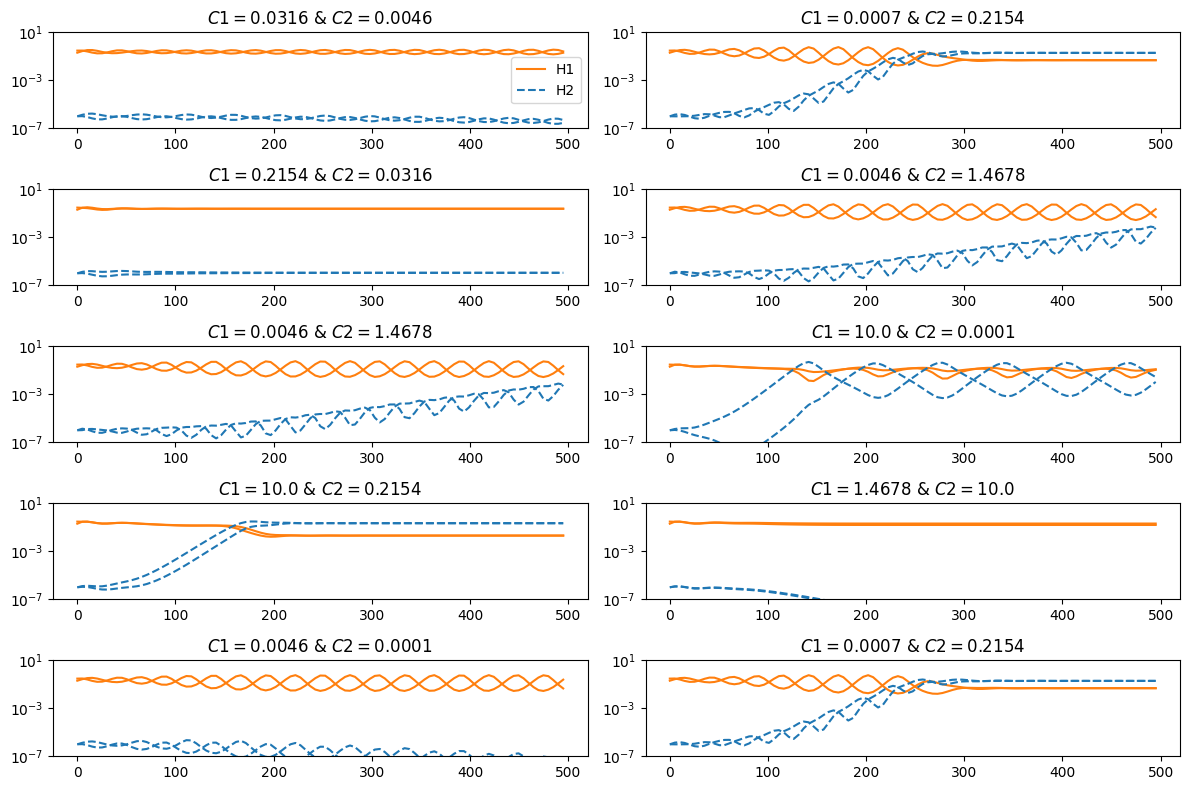

In [6]:
def rndpop():
    rnd = np.random.choice(np.geomspace(10**-4, 10**1, 7))
    return(rnd)

# time series
t_end = 500
number_steps = 100
t = np.linspace(0,t_end,number_steps)

c_1 = 0.001
c_2 = 0.001

fig, axs = plt.subplots(5,2, figsize=(12,8))
for i in range(10):
    row = i//2
    col = i%2
    var0 = [2, 2.5, 2.5, 2, 0.2, 0.3, 10**-6, 10**-6, 0, 0, 0, 0]
    var = []
    c_1 = rndpop()
    c_2 = rndpop()
    var = integ.odeint(slow, var0, t)
    # for i in range(len(var)):
    #     for j in range (len(var[i])):
    #         if (var[i][j] < 10**-6):
    #             var[i][j] = 10**-6
    axs[row, col].plot(t[-100:-1], var[-100:-1:, 4], "-", color="#FF7F0E", label="H1")
    axs[row,col].plot(t[-100:-1], var[-100:-1:, 5], "-", color="#FF7F0E")
    axs[row,col].plot(t[-100:-1], var[-100:-1:, 6], "--", color="#1F77B4", label="H2")
    axs[row,col].plot(t[-100:-1], var[-100:-1:, 7], "--", color="#1F77B4")
    axs[row,col].set_yscale("log")
    axs[row,col].set_ylim(10**-7,10**1)
    axs[row,col].set_title("$C1 = $" + str(np.round(c_1,4)) + " & $C2 = $" + str(np.round(c_2,4)))
    axs[0,0].legend()

plt.tight_layout()
plt.show()

[2, 2.5, 2.5, 2, 0.0013074445667988672, 0.16272050689296438, 0.0012966494032708726, 0.0026526792299579527, 0, 0, 0, 0]


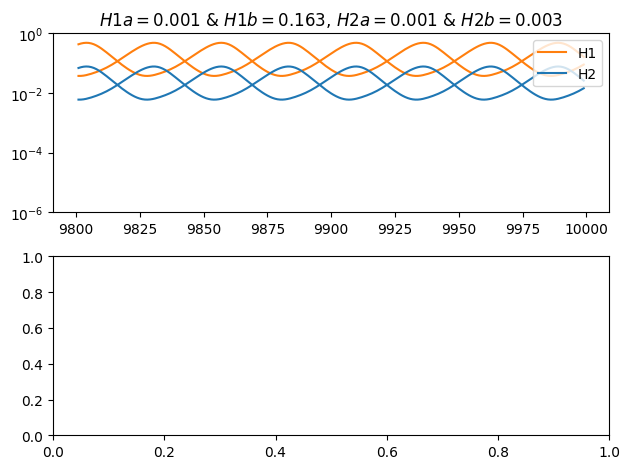

In [557]:
# time series
t_end = 10000
number_steps = 10000
t = np.linspace(0,t_end,number_steps)

c_1 = 0.01
c_2 = 0.01
var0 = [2, 2.5, 2.5, 2, rndpop(), rndpop(), rndpop(), rndpop(), 0, 0, 0, 0]
var = []
var = integ.odeint(slow, var0, t)
for i in range(len(var)):
    for j in range (len(var[i])):
        if (var[i][j] < 10**-6):
            var[i][j] = 10**-6
plt.subplot2grid((2,1),(0,0))
plt.plot(t[-200:-1], var[-200:-1:, 4], "-", color="#FF7F0E", label="H1")
plt.plot(t[-200:-1], var[-200:-1:, 5], "-", color="#FF7F0E")
plt.plot(t[-200:-1], var[-200:-1:, 6], "-", color="#1F77B4", label="H2")
plt.plot(t[-200:-1], var[-200:-1:, 7], "-", color="#1F77B4")
plt.legend(loc=1)
plt.yscale("log")
plt.ylim(10**-6,10**0)
plt.title("$H1a = $" + str(np.round(var0[4], 3)) + " & $H1b = $" + str(np.round(var0[5], 3)) +
           ", $H2a = $" + str(np.round(var0[6], 3)) + " & $H2b = $" + str(np.round(var0[7], 3)))
plt.subplot2grid((2,1),(1,0))
plt.tight_layout()
print(var0)

## H1 over c

In [ ]:
def find_maxima(x,n):
    """ returns an array with n extreme values of x"""
    
    max_index = signal.argrelmax(x)[0]         # create array with indices of local maxima of x
    
    extrema = x[max_index]                     # array with the actual values of the extrema
       
    if len(extrema) == 0:                      # if all values in x are the same and no extremum is found:
        extrema = np.append(extrema,x[-1])     #   return last value of x in this case
    while len(extrema) < n:                    # if less than n extrema have been found:
        extrema = np.append(extrema,extrema[0])#   repeat last extremum until array has n elements
    while len(extrema) > n:                    # if more than n extrema have been found:
        extrema = np.delete(extrema,-1)        #   delete elements until arrays has n elements
        
    return extrema

t_end = 2000
number_steps = 2000
t = np.linspace(0, t_end, number_steps)

# dispersal adaptability
c_range = np.geomspace(0.001, 10, 50) #100

# var = [N_a, N_b, A_a, A_b, H_1a, H_1b, H_2a, H_2b]
var0 = [2, 2.5, 2.5, 2, 0.2, 0.3, 0, 0, 0, 0, 0, 0]

num_extr = 2 # set number of maxima to be found

H1x_extr = []
H1y_extr = []
maxH1x = np.zeros(len(c_range))
maxH1y = np.zeros(len(c_range))

var = []

i = 0

for c_1 in tqdm(c_range):
    var = integ.odeint(slow, var0, t)

    H1x_extr.append(find_maxima(np.log(var[1500:2000,4]),num_extr))
    H1y_extr.append(find_maxima(np.log(var[1500:2000,5]),num_extr))

    # results[i,j] = ...
    maxH1x[i] = H1x_extr[-1]
    maxH1y[i] = H1y_extr[-1]

    # workaround to empty lists
    H2a_extr = []
    H2b_extr = []

    i += 1

# np.savetxt("./data/crowding/growthrate/H1Slope.csv", slopeH1, delimiter=",")
# np.savetxt("./data/crowding/growthrate/H2Slope.csv", slopeH2, delimiter=",")

In [41]:
t_end = 2000
number_steps = 2000
t = np.linspace(0, t_end, number_steps)

# dispersal adaptability
c_range = np.geomspace(0.001, 10, 300) #100

# var = [N_a, N_b, A_a, A_b, H_1a, H_1b, H_2a, H_2b]
var0 = [2, 2.5, 2.5, 2, 0.2, 0.3, 0, 0, 0, 0, 0, 0]


meandensity_H1x = np.zeros(len(c_range))
meandensity_H1y = np.zeros(len(c_range))

var = []

i = 0

for c_1 in tqdm(c_range):
    var = integ.odeint(slow, var0, t)
    #var[var < 1e-10] = 1e-10

    meandensity_H1x[i] = np.mean(var[-200:-1, 4])
    meandensity_H1y[i] = np.mean(var[-200:-1, 5])

    i += 1

100%|██████████| 300/300 [00:18<00:00, 16.28it/s]


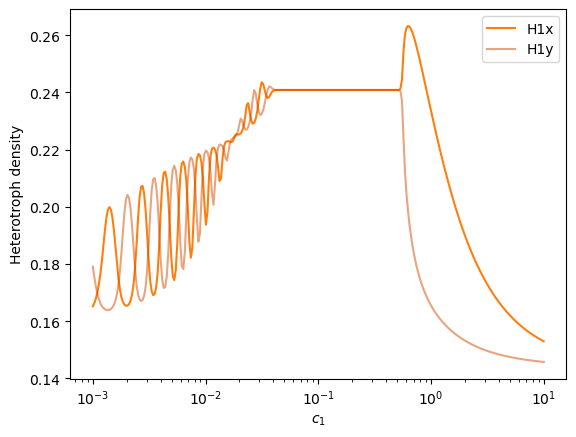

In [42]:
plt.plot(c_range, meandensity_H1x, label="H1x", color="#FF7F0E")
plt.plot(c_range, meandensity_H1y, label="H1y", color="#D44B00", alpha = 0.5)
plt.xscale("log")
plt.xlabel("$c_1$")
plt.ylabel("Heterotroph density")
plt.legend()

100%|██████████| 500/500 [00:07<00:00, 69.84it/s]


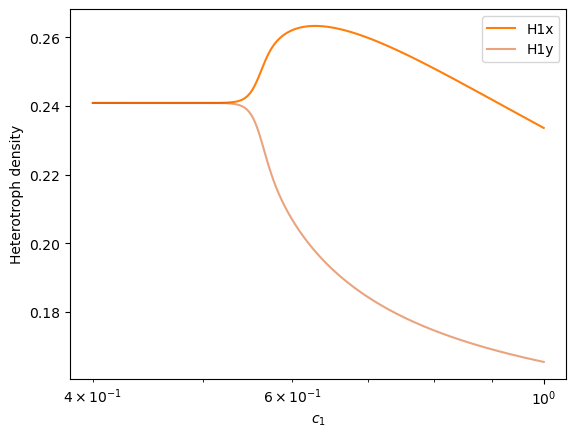

In [44]:
t_end = 2000
number_steps = 2000
t = np.linspace(0, t_end, number_steps)

# dispersal adaptability
c_range = np.geomspace(4*10**-1, 1, 500) #100

# var = [N_a, N_b, A_a, A_b, H_1a, H_1b, H_2a, H_2b]
var0 = [2, 2.5, 2.5, 2, 0.2, 0.3, 0, 0, 0, 0, 0, 0]


meandensity_H1x = np.zeros(len(c_range))
meandensity_H1y = np.zeros(len(c_range))

var = []

i = 0

for c_1 in tqdm(c_range):
    var = integ.odeint(slow, var0, t)
    #var[var < 1e-10] = 1e-10

    meandensity_H1x[i] = np.mean(var[-200:-1, 4])
    meandensity_H1y[i] = np.mean(var[-200:-1, 5])

    i += 1

plt.plot(c_range, meandensity_H1x, label="H1x", color="#FF7F0E")
plt.plot(c_range, meandensity_H1y, label="H1y", color="#D44B00", alpha = 0.5)
plt.xscale("log")
plt.xlabel("$c_1$")
plt.ylabel("Heterotroph density")
plt.legend()

100%|██████████| 500/500 [00:06<00:00, 80.86it/s]


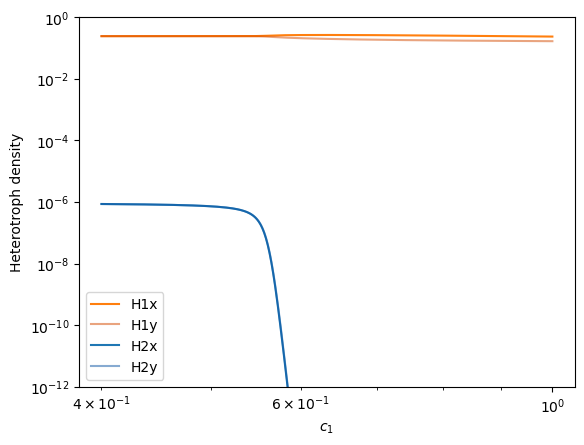

In [50]:
t_end = 2000
number_steps = 2000
t = np.linspace(0, t_end, number_steps)

# dispersal adaptability
c_range = np.geomspace(4*10**-1, 1, 500) #100

# var = [N_a, N_b, A_a, A_b, H_1a, H_1b, H_2a, H_2b]
var0 = [2, 2.5, 2.5, 2, 0.2, 0.3, 10**-6, 10**-6, 0, 0, 0, 0]


meandensity_H1x = np.zeros(len(c_range))
meandensity_H1y = np.zeros(len(c_range))
meandensity_H2x = np.zeros(len(c_range))
meandensity_H2y = np.zeros(len(c_range))

var = []

i = 0

for c_1 in tqdm(c_range):
    var = integ.odeint(slow, var0, t)
    #var[var < 1e-10] = 1e-10

    meandensity_H1x[i] = np.mean(var[-200:-1, 4])
    meandensity_H1y[i] = np.mean(var[-200:-1, 5])
    meandensity_H2x[i] = np.mean(var[-200:-1, 6])
    meandensity_H2y[i] = np.mean(var[-200:-1, 7])

    i += 1

plt.plot(c_range, meandensity_H1x, label="H1x", color="#FF7F0E")
plt.plot(c_range, meandensity_H1y, label="H1y", color="#D44B00", alpha = 0.5)
plt.plot(c_range, meandensity_H2x, label="H2x", color="#1F77B4")
plt.plot(c_range, meandensity_H2y, label="H2y", color="#0F57A4", alpha = 0.5)
plt.xscale("log")
plt.yscale("log")
plt.ylim(10**-12,10**0)
plt.xlabel("$c_1$")
plt.ylabel("Heterotroph density")
plt.legend()